In this notebook we will first implement a simplified version of the DCM model, in order to generate data for subsequent examples.

In [1]:
import numpy
# use a consistent seed so that everyone has the same data
numpy.random.seed(1000)

import os,sys
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.insert(0,'../utils')
from mkdesign import create_design_singlecondition
from graph_utils import show_graph_from_adjmtx
import math
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor
import scipy.interpolate

results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)


In [2]:
# first let's build the model without the bilinear influence (aka PPI)
# after http://spm.martinpyka.de/?p=81
nregions=5
z=numpy.zeros(nregions)

# intrinsic connectivity
A=numpy.zeros((z.shape[0],z.shape[0]))
A=numpy.diag(numpy.ones(z.shape[0])*-1)
# add some structure
#A=A + numpy.diag(numpy.ones(z.shape[0]-1),k=-1)
A[2,1]=1
A[3,1]=1
B=numpy.zeros(A.shape)
B[2,0]=1
B[4,0]=1

C=numpy.zeros((z.shape[0],1))
C[0]=1
u=0

print (A)
print (B)
print (C)

# we are assuming a 1 second TR for the resulting data
# but the neural data are at a 1/16 millisecond time resolution
stepsize=.01
tslength=300
timepoints=numpy.arange(0,tslength,stepsize)

# create a blocked design
d,design=create_design_singlecondition(blockiness=1.0,deslength=tslength,blocklength=20,offset=20)

u=scipy.interpolate.griddata(numpy.arange(1,d.shape[0]),d,timepoints,fill_value=0)

def dcm_model(t,z,A,B,C,u):
    ut=numpy.abs(timepoints - t).argmin() 
    return (A.dot(z)+ u[ut]*B.dot(z) + C.dot(u[ut]).T)[0] 

def mk_dcm_dataset(timepoints,z,noise_sd):
    data=numpy.zeros((len(timepoints),len(z)))
    for i in range(1,len(timepoints)):
        data[i,:]=data[i-1,:] + dcm_model(timepoints[i],data[i-1,:],A,B,C,u)  + numpy.random.randn(len(z))*noise_sd 
    hrf=spm_hrf(stepsize,oversampling=1)
    data_conv=numpy.zeros(data.shape)
    for i in range(len(z)):
        data_conv[:,i]=numpy.convolve(data[:,i],hrf)[:data.shape[0]]        
    return data,data_conv    

[[-1.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.]
 [ 0.  1.  0. -1.  0.]
 [ 0.  0.  0.  0. -1.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]]
[[ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


../utils/mkdesign.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  design[b:b+blocklength]=1


In [3]:
noise_sd=2
data,data_conv=mk_dcm_dataset(timepoints,z,noise_sd)
numpy.savez(os.path.join(results_dir,'dcmdata.npz'),data=data_conv,A=A,B=B,C=C,u=u,d=d,design=design)

correlation matrix
[[ 1.         -0.09707085  0.9631521   0.00367084  0.98511904]
 [-0.09707085  1.          0.08479289  0.71148747 -0.06830046]
 [ 0.9631521   0.08479289  1.          0.12912149  0.95596707]
 [ 0.00367084  0.71148747  0.12912149  1.          0.03603157]
 [ 0.98511904 -0.06830046  0.95596707  0.03603157  1.        ]]


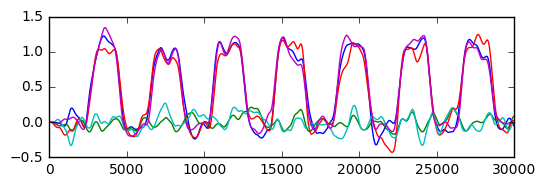

In [4]:
plt.subplot(211)
plt.plot(data_conv)
cc=numpy.corrcoef(data_conv.T)
print ('correlation matrix')
print (cc)
from sklearn.covariance import GraphLassoCV
import matplotlib.colors


In [5]:
glasso=GraphLassoCV()
glasso.fit(data_conv)

GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

partial r^2 matrix
[[  0.00000000e+00   0.00000000e+00   1.88851794e-01   0.00000000e+00
    4.87627057e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.12385351e-02
    0.00000000e+00]
 [  1.88851794e-01   0.00000000e+00   0.00000000e+00   1.06233643e-04
    8.92322420e-02]
 [  0.00000000e+00   1.12385351e-02   1.06233643e-04   0.00000000e+00
    0.00000000e+00]
 [  4.87627057e-01   0.00000000e+00   8.92322420e-02   0.00000000e+00
    0.00000000e+00]]


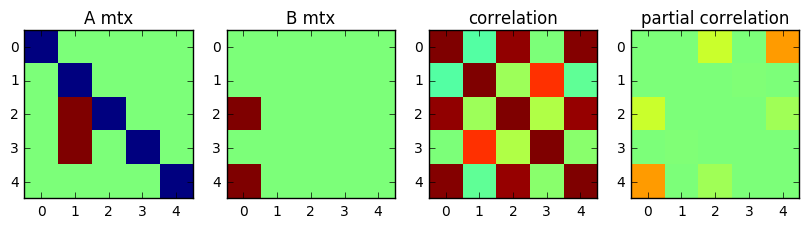

In [6]:

from pcor_from_precision import pcor_from_precision
pcor=pcor_from_precision(glasso.precision_)
print ('partial r^2 matrix')
print (pcor**2)

plt.figure(figsize=(10,5))
plt.subplot(141)
plt.imshow(A,interpolation='nearest',norm=matplotlib.colors.Normalize(vmin=-1,vmax=1))
plt.title('A mtx')
plt.subplot(142)
plt.imshow(B,interpolation='nearest',norm=matplotlib.colors.Normalize(vmin=-1,vmax=1))
plt.title('B mtx')
plt.subplot(143)
plt.imshow(cc,interpolation='nearest',norm=matplotlib.colors.Normalize(vmin=-1,vmax=1))
plt.title('correlation')
plt.subplot(144)
plt.imshow(pcor**2,interpolation='nearest',norm=matplotlib.colors.Normalize(vmin=-1,vmax=1))
plt.title('partial correlation')


###Show the true graph

[(0, 2), (0, 4), (1, 2), (1, 3), ('u', 0)]
Black: input
Red: unmodulated
Blue: modulated


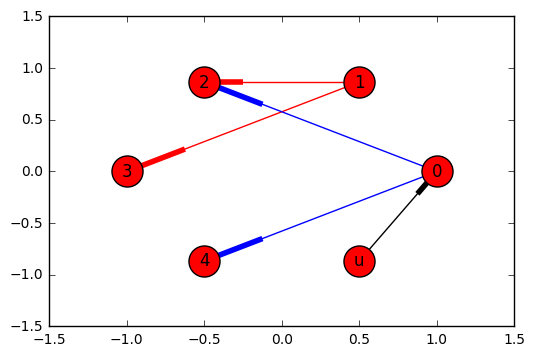

In [7]:
gr=show_graph_from_adjmtx(A,B,C)

## Run an analysis using SPM

Now we will run an actual DCM analysis on these data using SPM.

1.Start spm using the command: 

    spm fmri
    
2.Click the "Dynamic causal modelling" button on the main panel

3.From the "Action" menu, choose "specify".  

#### Model 1: True model

The selection menu should automatically go to the directory where the relevant files are (/home/vagrant/fmri-analysis-vm/analysis/connectivity/dcmfiles).  Assuming that it does, then first select the SPM.mat file listed in the directory, and click "Done" at the bottom.  The SPM.mat file contains a description of the experimental design that DCM needs.

You will be asked for the name: enter "truemodel"

Another file selector will appear, which is asking you to select the ROI files.  You should select all 5 of the VOI\* files that are listed in the selector.  They need to be selected in order; the best way to do this is to hold the Shift key and click the last file in the list, which will select the entire set in order. Click "Done" again.  

You will be asked for a number of details about the design, for which you can just accept the default values.

Now we have to specify the three matrices in the SPM model (A,B, and C).  You will see a window that asks you to click radio buttons for the active connections.  For the A matrix, we need to include both the static and modulated connections from the A and B matrices above.  Your entry should look like this:

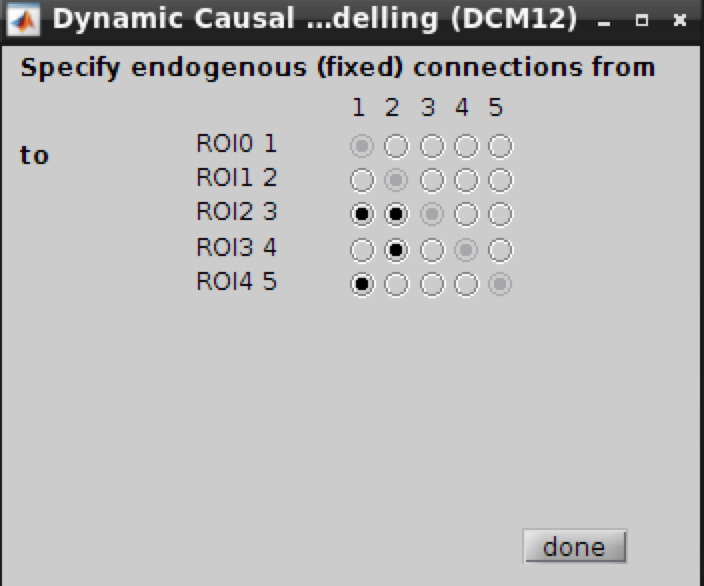

In [8]:
from IPython.display import Image
Image(filename='DCM_Amtx.png',retina=True) 

Click "done", which will take you to the next window to specify the B and C matrices.  Your entries should look like this:

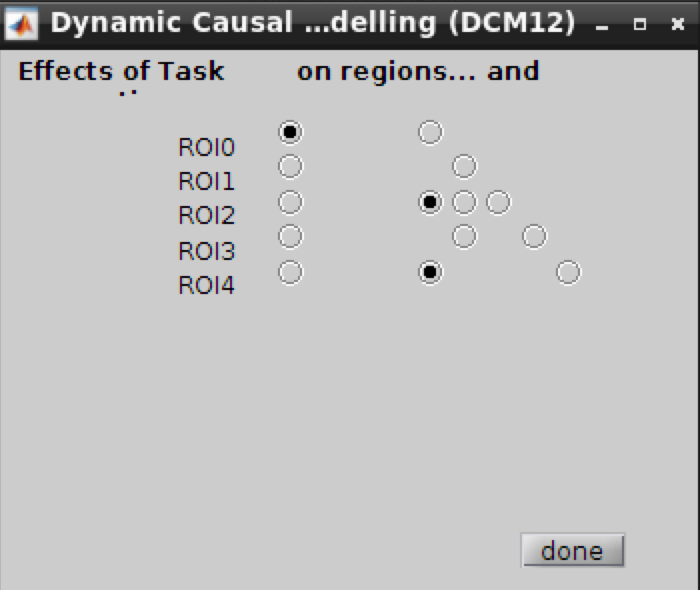

In [9]:
Image(filename='DCM_BCmtx.png',retina=True) 

This will create a file called "DCM_truemodel.mat" in the same directory as the other files.

Now estimate the model by clicking the DCM button, choosing "estimate" from the Action menu, and selecting "DCM_truemodel.mat" from the selector.  This will take a few minutes to compute.

####Model 2: no modulation

Now let's specify the same model, but without any modulated connections.  We can do this using MATLAB code rather than doing it by hand. 

From the Utils menu, choose "Run M-file".  Using the file selector, go one directory up ('..') and select "mk_model_noppi.m". This will specify the model without modulation (i.e. with no nonzero entries in the B matrix) and then estimate it, saving the results to a file called "DCM_noppi.mat'.

####Model 3: incorrect modulation

Now let's specify the same model, but with two incorrect modulated connections (so that it has the same number of parameters as the true model). Using the "Run M-file" command, select "mk_model_wrongppi.m"



## Bayesian model comparison

A fundamental part of the DCM workflow is the comparison of models.  In this case, we can test for the PPI by comparing the three models that we just created.  

Choose "Dynamic causal modelling -> Action -> compare"

This will bring up a batch editor, in which we need to specify several variables.

1. Double click on "Directory" and select the current directory (".")
2. Click on "Inference method" and choose "Fixed effects" and click "specify"
3. Click "Data" then in the window below click "New subject". Then click ". Subject" under Data above, and choose "New Session" below.  Then click on "Models" above, click "Specify", and choose the the three DCM\*.mat files that we created above, in the order truemodel, noppi, wrongppi.
4. Click the green arrow at the top to run the batch model.


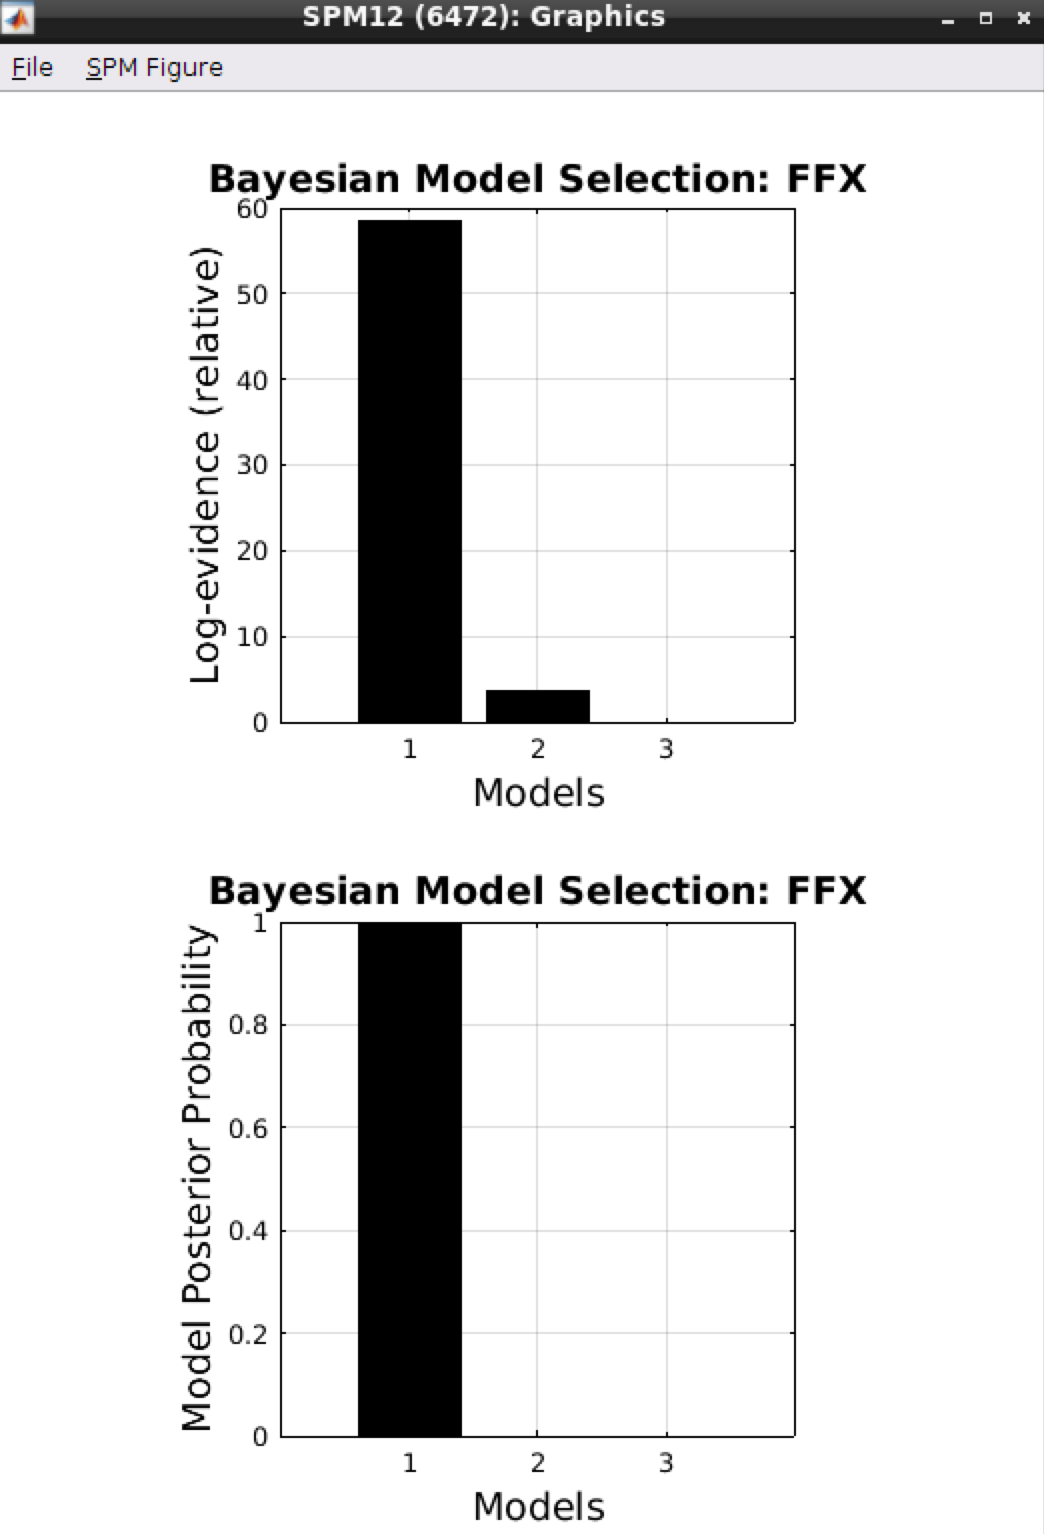

In [10]:
Image(filename='DCM_BMS.png',retina=True) 

This tells us that the evidence for the first model (the true model) is much greater than that for the other (incorrect) models.